In [2]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings
import flash_attn

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed
from scipy.sparse import csr_matrix, csc_matrix


os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

In [24]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.set_figure_params(facecolor = "white", dpi=80)

-----
anndata     0.10.9
scanpy      1.9.8
-----
PIL                 10.4.0
aiohappyeyeballs    2.4.0
aiohttp             3.10.5
aiosignal           1.2.0
asttokens           NA
async_timeout       4.0.2
attr                21.4.0
brotli              1.1.0
certifi             2024.08.30
cffi                1.17.1
charset_normalizer  3.3.2
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
datasets            2.21.0
dateutil            2.9.0.post0
debugpy             1.8.5
decorator           5.1.1
defusedxml          0.7.1
dill                0.3.8
einops              0.8.0
exceptiongroup      1.2.2
executing           2.1.0
filelock            3.16.1
flash_attn          NA
frozenlist          1.3.0
fsspec              2024.6.1
google              NA
gseapy              1.1.3
h5py                3.11.0
huggingface_hub     0.25.0
idna                3.10
igraph              0.11.6
ipykernel           6.29.5
jedi                0.19.1
joblib              1.4.2
ki

In [3]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

In [4]:
model_dir = Path("//samurlab1/Joshua/scGPT_models/")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab: 
        vocab.append_token(s)

with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from //samurlab1/Joshua/scGPT_models/best_model.pt, the model args will override the config //samurlab1/Joshua/scGPT_models/args.json.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwis

In [6]:
import scanpy as sc
import anndata as ad
import numpy as np
import warnings as wrn

wrn.filterwarnings("ignore")

import pooch


In [7]:
adata = sc.read('/samurlab1/Joshua/h5ad/neuts.h5ad')
adata.obs['active.ident']

Myeloid_BM_234868_AAACCCAAGAGTCTTC-1       S100A8+LTF+imtr_neut
Myeloid_BM_234868_AAACCCAGTGAGGCAT-1    S100A8/9+MMP9+imtr_neut
Myeloid_BM_234868_AAACCCAGTTCTCCTG-1       Malat1+NCF1+mat_neut
Myeloid_BM_234868_AAACCCATCCCATTCG-1       Malat1+NCF1+mat_neut
Myeloid_BM_234868_AAACGCTAGGAGCAAA-1    S100A8/9+MMP9+imtr_neut
                                                 ...           
Myeloid_OL_551452_TTTGGTTCATGGCGCT-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGGTTTCATATGGC-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGAGACATATG-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGAGCTGCGAA-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGTCTAGTCAG-1      FCGR3B+CXCR2+mat_neut
Name: active.ident, Length: 84616, dtype: category
Categories (9, object): ['FCGR3B+CXCR2+mat_neut', 'S100A8+CD14+MAC', 'S100A8/9+MMP9+imtr_neut', 'LTF+CAMP+imtr_neut', ..., 'CXCL8+VEGFA+mat_neut', 'Malat1+NCF1+mat_neut', 'Mki67+DEFA3+pre-neut', 'HLA-DR+CD16+mac']

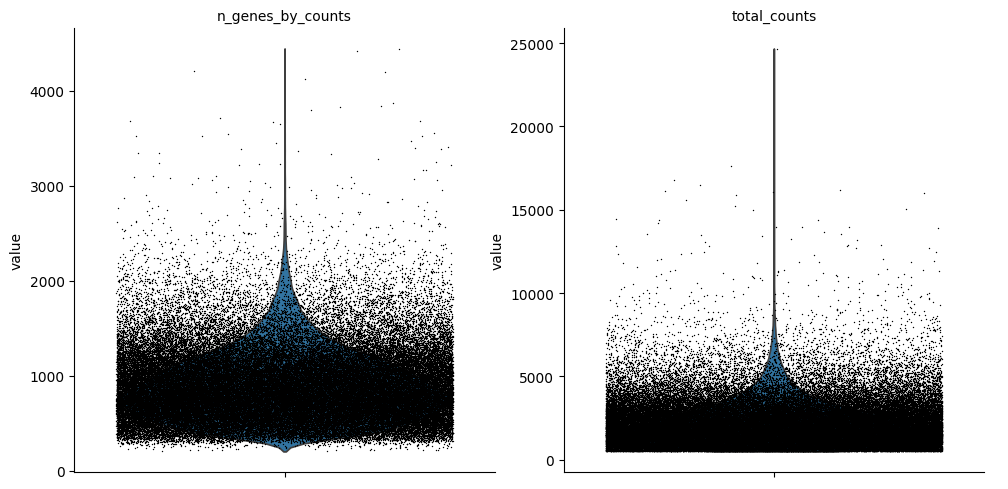

In [8]:
adata.var_names_make_unique()
adata.var

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)

#mitrochondrial genes removal "MT-" for human, "Mt- for mouse"
adata.var["MT"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["MT"], percent_top=None, log1p=False, inplace=True
)
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))

sc.pl.violin(
    adata,
    ["n_genes_by_counts","total_counts"],
    jitter = 0.4,
    multi_panel = True
)



In [9]:
adata.var_names
adata.var_names_make_unique()
adata.var

,name,n_cells,MT,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ribo
AL627309.1,AL627309.1,376,False,376,0.004562,99.555640,386.0,False
AL669831.5,AL669831.5,716,False,716,0.008793,99.153824,744.0,False
LINC00115,LINC00115,300,False,300,0.003735,99.645457,316.0,False
FAM41C,FAM41C,890,False,890,0.010920,98.948189,924.0,False
AL645608.3,AL645608.3,26,False,26,0.000307,99.969273,26.0,False
...,...,...,...,...,...,...,...,...
AL121820.1,AL121820.1,6,False,6,0.000071,99.992909,6.0,False
AC021483.1,AC021483.1,9,False,9,0.000106,99.989364,9.0,False
RHCG,RHCG,8,False,8,0.000130,99.990546,11.0,False
IGLON5,IGLON5,7,False,7,0.000118,99.991727,10.0,False


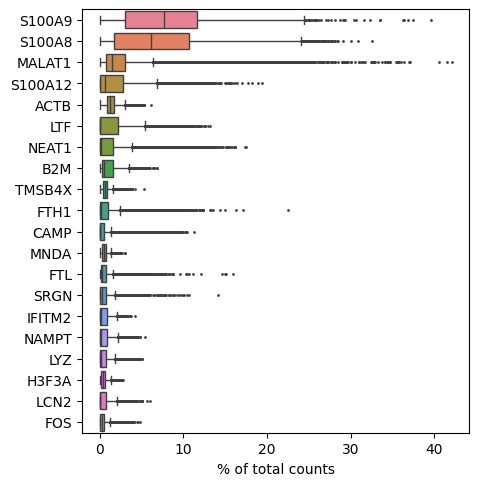

In [11]:
from scipy.sparse import csr_matrix, csc_matrix

# Check if adata.X is sparse (either csr_matrix or csc_matrix) and convert to dense
if isinstance(adata.X, (csr_matrix, csc_matrix)):
    adata.X = adata.X.toarray()  # Convert sparse matrix to dense array

sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
# Specify data path; here we load the Immune Human dataset
data_dir = Path("/samurlab1/Joshua/h5ad")
#I have some data I already imported above so I will comment out above code
adata = sc.read(
    str(data_dir / "neuts.h5ad"), cache=True
)  # 33506 × 12303
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["active.ident"].astype(str)
data_is_raw = False
adata.var_names_make_unique()
adata.var

,name
AL627309.1,AL627309.1
AL669831.5,AL669831.5
LINC00115,LINC00115
FAM41C,FAM41C
AL645608.3,AL645608.3
...,...
GOLGA8J,GOLGA8J
AC066612.2,AC066612.2
AC087190.2,AC087190.2
AC018552.2,AC018552.2


In [14]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v5" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
print(adata.obs.columns)
#preprocessor(adata, batch_key="batch")

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted',
       'predicted.1', 'predicted.2', 'predicted.3', 'predicted.4', 'CD16',
       'MPI', 'AMDI', 'gene_siefert_m2', 'gene_siefert_m1', 'gene_siefert_m0',
       'active.ident', 'tissue', 'patient', 'stage', 'nCount_SCT',
       'nFeature_SCT', 'SCT_snn_res.0.25', 'seurat_clusters', 'ident',
       'celltype'],
      dtype='object')


In [16]:
from scipy.sparse import csr_matrix, csc_matrix

# Check if adata.X is sparse (either csr_matrix or csc_matrix) and convert to dense
if isinstance(adata.X, (csr_matrix, csc_matrix)):
    adata.X = adata.X.toarray()  # Convert sparse matrix to dense array
preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


In [17]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [18]:
# Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 941 genes.


In [19]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 941/941 [00:00<00:00, 466309.08it/s]


In [20]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

In [21]:
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [22]:
# Here are the gene programs identified
mgs

{'3': ['BAG3',
  'HSPA1B',
  'HSPA6',
  'IER5',
  'DNAJB1',
  'HSPB1',
  'DNAJA4',
  'ZFAND2A',
  'HSPA1A'],
 '1': ['PRTN3',
  'MS4A3',
  'DEFA4',
  'CTSG',
  'AZU1',
  'MPO',
  'ELANE',
  'RNASE3',
  'RNASE2'],
 '16': ['PPP2R2B', 'PRKN', 'ANK3', 'NKAIN2', 'PSD3', 'LSAMP'],
 '38': ['S100A9', 'LYZ', 'S100A12', 'RETN', 'S100A8'],
 '6': ['PDZK1IP1', 'OLFM4', 'PI3', 'SCGB3A2', 'SLPI', 'LTF', 'LCN2'],
 '25': ['PDK4', 'MT2A', 'MT1E', 'SPINK1', 'MT1X', 'MT1M'],
 '17': ['PARD3', 'ZNF521', 'PLCB4', 'EBF1', 'PDE3A', 'MEIS1'],
 '36': ['IL2RA', 'MIR155HG', 'CCL22', 'DUSP4', 'TNFRSF18'],
 '2': ['NUSAP1',
  'PTTG1',
  'KPNA2',
  'CCNB1',
  'CKS1B',
  'CCNA2',
  'CDK1',
  'TOP2A',
  'UBE2C'],
 '18': ['NUPR1', 'LINC02154', 'GPNMB', 'BHLHE41', 'CCL18', 'PHLDA3'],
 '12': ['PCLAF', 'MNS1', 'PCNA', 'RECQL', 'TYMS', 'FAM111B', 'RRM2'],
 '4': ['IFIT2', 'IFIT3', 'ISG15', 'MX1', 'IFIT1', 'RSAD2', 'HERC5', 'IFI44L'],
 '20': ['NUAK1', 'MRPS30-DT', 'FAM81A', 'FNIP2', 'GCNT4', 'ZNF365'],
 '15': ['MAP9', 'ENO2', '

computing score '3_SCORE'
    finished: added
    '3_SCORE', score of gene set (adata.obs).
    191 total control genes are used. (0:00:00)
computing score '104_SCORE'
    finished: added
    '104_SCORE', score of gene set (adata.obs).
    134 total control genes are used. (0:00:00)
computing score '181_SCORE'
    finished: added
    '181_SCORE', score of gene set (adata.obs).
    113 total control genes are used. (0:00:00)
computing score '269_SCORE'
    finished: added
    '269_SCORE', score of gene set (adata.obs).
    64 total control genes are used. (0:00:00)
computing score '185_SCORE'
    finished: added
    '185_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score '1_SCORE'
    finished: added
    '1_SCORE', score of gene set (adata.obs).
    141 total control genes are used. (0:00:00)
computing score '88_SCORE'
    finished: added
    '88_SCORE', score of gene set (adata.obs).
    183 total control genes are used. (0:00:00)
com

<Figure size 400x1040 with 0 Axes>

<Figure size 320x320 with 0 Axes>

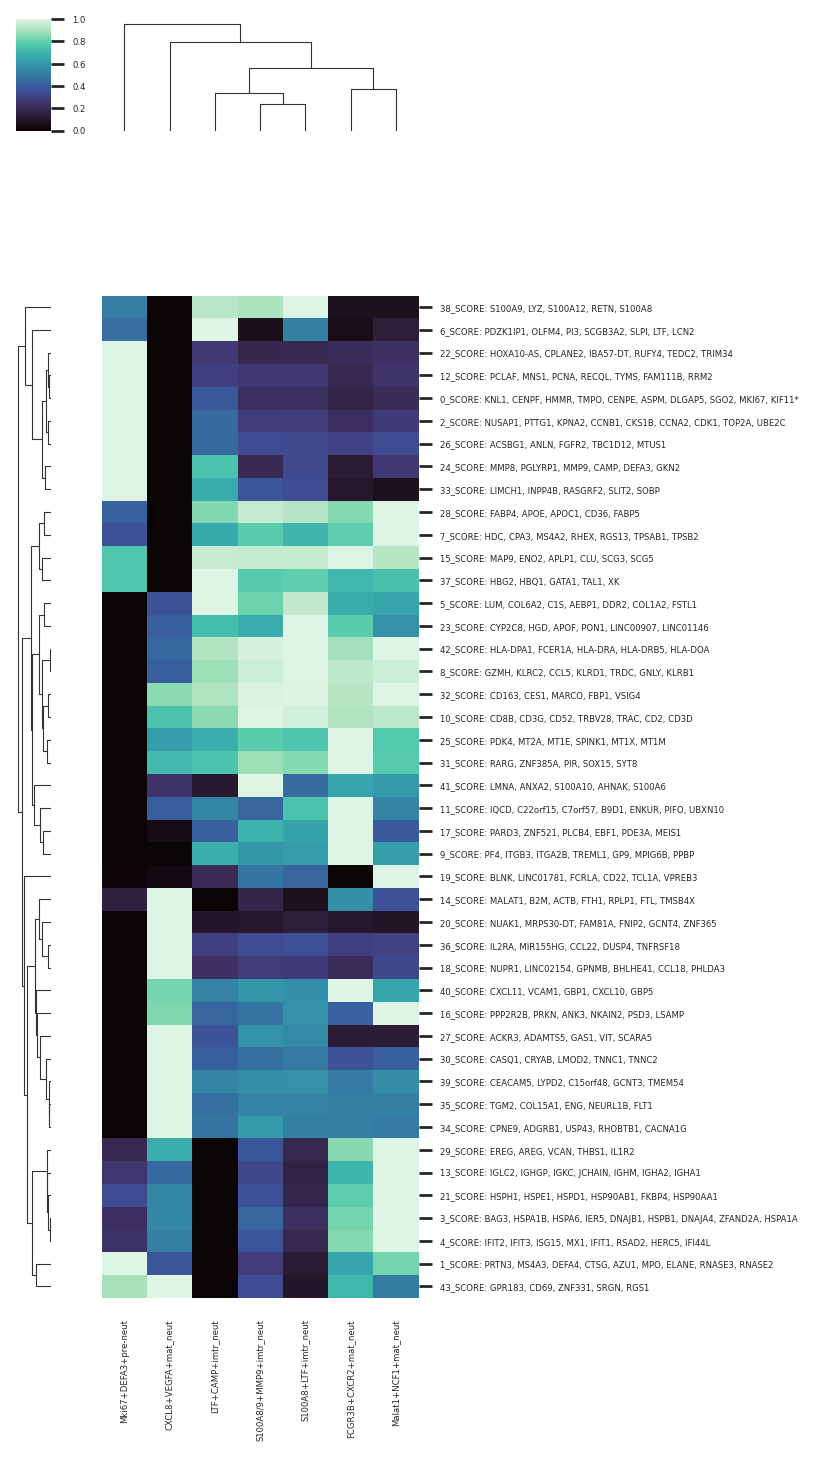

In [25]:
sns.set(font_scale=0.35)
embed.score_metagenes(adata, metagenes)
embed.plot_metagenes_scores(adata, mgs, "celltype")